Arnau Solé Porta (NIU: 1630311)

### Introduction

In [1]:
# Install packages
%%capture
!pip install py-trees

In [5]:
# Import packages
from time import sleep
from py_trees.composites import Selector
from py_trees.behaviour import Behaviour
from py_trees.composites import Sequence
from py_trees import common
from py_trees.common import Status
from py_trees import logging as log_tree
from py_trees.display import render_dot_tree
import matplotlib.pyplot as plt
import matplotlib.image as img
import py_trees as pt
import asyncio

In [ ]:
following = False
hungry = False

In [11]:
class Normal(pt.behaviour.Behaviour):
    def __init__(self):
        print("Initializing Normal")
        super(Normal, self).__init__("Normal")

    def initialise(self):
        pass

    def update(self):
        print('Siuu')
        return pt.common.Status.SUCCESS

    def terminate(self, new_status: common.Status):
        pass

In [18]:
async def count_time():
    print('Hi')
    await asyncio.sleep(3)
    print("Hungry!")
    return True

In [34]:
class Count(pt.behaviour.Behaviour):
    def __init__(self):
        print("Initializing Count")
        super(Count, self).__init__("Count")

    def initialise(self):
        pass

    def update(self):
          count_time()
          return pt.common.Status.SUCCESS

    def terminate(self, new_status: common.Status):
        pass

In [31]:
log_tree.level = log_tree.Level.DEBUG

treeRoot = pt.composites.Parallel(name="root", policy=pt.common.ParallelPolicy.SuccessOnAll())
treeRoot.add_children([Normal(), Count()])

treeRoot.tick_once()

Initializing Normal
Initializing Count
[DEBUG] root                 : Parallel.tick()
[DEBUG] root                 : Parallel.tick(): re-initialising
[DEBUG] Normal               : Normal.tick()
Siuu
[DEBUG] Normal               : Normal.stop(Status.INVALID->Status.SUCCESS)
[DEBUG] Count                : Count.tick()
[DEBUG] Count                : Count.stop(Status.INVALID->Status.SUCCESS)
[DEBUG] root                 : Parallel.stop()[Status.INVALID->Status.SUCCESS]


<ipython-input-30-5ff8a80304e6>:10: RuntimeWarning: coroutine 'count_time' was never awaited
  count_time()


In [13]:
class BTRoam:
    def __init__(self):
        self.root = pt.composites.Parallel("Parallel", policy=pt.common.ParallelPolicy.SuccessOnAll())
        self.root.add_children([Normal(), Count()])

        self.behaviour_tree = pt.trees.BehaviourTree(self.root)

    # Function to set invalid state for a node and its children recursively
    def set_invalid_state(self, node):
        node.status = pt.common.Status.INVALID
        for child in node.children:
            self.set_invalid_state(child)

    def stop_behaviour_tree(self):
        # Setting all the nodes to invalid, we force the associated asyncio tasks to be cancelled
        self.set_invalid_state(self.root)

    async def tick(self):
        self.behaviour_tree.tick()
        await asyncio.sleep(0)


### Avoid other critters

Highest priority action. If the agent detects a critter when it is not performing an action, it will rotate 180 degrees, set the variable following to false and return true

In [ ]:
class Is_Critter(pt.behaviour.Behaviour):
    def __init__(self, aagent):
        self.my_goal = None
        print("Initializing Is_Critter")
        super(Is_Critter, self).__init__("Is_Critter")
        self.my_agent = aagent

    def initialise(self):
        pass

    def update(self):
        sensor_obj_info = self.my_agent.rc_sensor.sensor_rays[Sensors.RayCastSensor.OBJECT_INFO]
        for index, value in enumerate(sensor_obj_info):
            if value:  # there is a hit with an object
                if value["tag"] == "CritterMantaRay":  # If it is another critter
                    print("A critter! Run!")
                    following = False
                    return pt.common.Status.SUCCESS

        return pt.common.Status.FAILURE

    def terminate(self, new_status: common.Status):
        pass

### Eat flowers

Second highest priority action. If the agent is hungry and detects a flower, it will approach it and eat for 5 seconds, set following to false and continue

In [ ]:
class Is_Hungry(pt.behaviour.Behaviour):
    def __init__(self, aagent):
        self.my_goal = None
        print("Initializing Is_Hungry")
        super(Is_Hungry, self).__init__("Is_Hungry")
        self.my_agent = aagent

    def initialise(self):
        pass

    def update(self):
        if hungry:
          print("I am hungry!")
          return pt.common.Status.SUCCESS

        return pt.common.Status.FAILURE

    def terminate(self, new_status: common.Status):
        pass

In [ ]:
class Is_Flower(pt.behaviour.Behaviour):
    def __init__(self, aagent):
        self.my_goal = None
        print("Initializing Is_Flower")
        super(Is_Flower, self).__init__("Is_Flower")
        self.my_agent = aagent

    def initialise(self):
        pass

    def update(self):
        sensor_obj_info = self.my_agent.rc_sensor.sensor_rays[Sensors.RayCastSensor.OBJECT_INFO]
        for index, value in enumerate(sensor_obj_info):
            if value:  # there is a hit with an object
                if value["tag"] == "Flower":  # If it is another critter
                    print("Flower found!")
                    following = False
                    return pt.common.Status.SUCCESS

        return pt.common.Status.FAILURE

    def terminate(self, new_status: common.Status):
        pass

### Follow astronaut

Third highest priority action. If the agent encouters an astronaut, it will follow it until it loses its track or other higher priority action is triggered.

In [ ]:
class Is_Astronaut(pt.behaviour.Behaviour):
    def __init__(self, aagent):
        self.my_goal = None
        print("Initializing Is_Astronaut")
        super(Is_Astronaut, self).__init__("Is_Astronaut")
        self.my_agent = aagent

    def initialise(self):
        pass

    def update(self):
        sensor_obj_info = self.my_agent.rc_sensor.sensor_rays[Sensors.RayCastSensor.OBJECT_INFO]
        for index, value in enumerate(sensor_obj_info):
            if value:  # there is a hit with an object
                if value["tag"] == "Astronaut":  # If it is another critter
                    print("Astronaut encountered!")
                    following = True
                    return pt.common.Status.SUCCESS

        return pt.common.Status.FAILURE

    def terminate(self, new_status: common.Status):
        pass

### Search for astronaut

This action is triggered when the agent was following the astronaut and it loses its track. The agent will look for it a bit, if it finds it we will return to follow astronaut, if not we will stop following/searching the astronaut

In [ ]:
class Is_Following(pt.behaviour.Behaviour):
    def __init__(self, aagent):
        self.my_goal = None
        print("Initializing Is_Following")
        super(Is_Following, self).__init__("Is_Following")
        self.my_agent = aagent

    def initialise(self):
        pass

    def update(self):
        if following:
          print("Astronaut lost!")
          return pt.common.Status.SUCCESS

        return pt.common.Status.FAILURE

    def terminate(self, new_status: common.Status):
        pass

### Global tree

In [ ]:
class GlobalBT:
    def __init__(self, aagent):
        # Initialize agent atributes
        self.aagent = aagent
        self.initTime = time.time()
        self.timer = 0
        self.hungry = False
        self.following = False

        # Create main tree
        avoid = pt.composites.Sequence(name="Avoid critter", memory=True)
        avoid.add_children([Is_Critter(aagent), Avoiding(aagent)])

        eat = pt.composites.Sequence("Eat", memory=True)
        eat.add_children([Is_Hungry(aagent), Is_Flower(aagent), Eating(aagent)])

        follow = pt.composites.Sequence("Follow astronaut", memory=True)
        follow.add_children([Is_Astronaut(aagent), Following(aagent)])

        search = pt.composites.Sequence("Search astronaut", memory=True)
        search.add_children([Is_Following(aagent), Searching(aagent)])

        self.root = pt.composites.Selector(name="Selector", memory=False)
        self.root.add_children([avoid(aagent), eat(aagent), follow(aagent), search(aagent), roam(aagent)])

        self.behaviour_tree = pt.trees.BehaviourTree(self.root)

    # Function to set invalid state for a node and its children recursively
    def set_invalid_state(self, node):
        node.status = pt.common.Status.INVALID
        for child in node.children:
            self.set_invalid_state(child)

    def stop_behaviour_tree(self):
        # Setting all the nodes to invalid, we force the associated asyncio tasks to be cancelled
        self.set_invalid_state(self.root)

    async def tick(self):
        self.timer = time.time() - self.initTime
        if self.time < 15:
          self.hungry = False
        else:
          self.hungry = True
        self.behaviour_tree.tick()
        await asyncio.sleep(0)

# Other

###Exercise 1: Build and run a simple tree

In [ ]:
# A: Implement a condition node that always returns failure

class AlwaysFail(Behaviour):
    def __init__(self, name):
        super(AlwaysFail, self).__init__(name)
        """ The constructor of this class """


    def setup(self):
        self.logger.debug(f"AlwaysFail::setup {self.name}")
        """ This mehod Allows you to do some more initialization later, which cannot yet be done yet at the time of construction
            (e.g. after the node has been added to the tree).
            If you want to use this method you need to write the code that calls it yourself.
            However, you can probably ignore this method.
        """

    def initialise(self):
        self.logger.debug(f"AlwaysFail::initialise {self.name}")
        """
            This method is called whenever a new execution of the action corresponding to this node must be started.
            That is, it is called when the node is ticked and:
                - This node has not been ticked before, or
                - After the previous tick, this node returned SUCCES or FAILURE
            So, if this node is ticked, and on the previous tick it returned RUNNING, then this method will *not* be called.
        """

    def update(self):
        self.logger.debug(f"AlwaysFail::update {self.name}")
        """
            This method is called every time the node is ticked.
            It must return SUCCESS, FAILURE, or RUNNING.
        """
        return Status.FAILURE

    def terminate(self, new_status:Status):
        self.logger.debug(f"AlwaysFail::terminate {self.name}. Terminated with status {new_status}")
        """
            This method is called whenever the action corresponding to this node has finished its execution.
            That is, if the update() method has returned either SUCCESS or FAILURE.
        """

In [ ]:
# B: Implement main

log_tree.level = log_tree.Level.DEBUG

treeRoot = Selector(name="root", memory=False)
insideHouse = AlwaysFail(name="inside house")
walkThroughDoor = AlwaysSuccess(name="walk through door")

treeRoot.add_children([insideHouse, walkThroughDoor])

treeRoot.tick_once()

[DEBUG] root                 : Selector.tick()
[DEBUG] root                 : Selector.tick() [!RUNNING->reset current_child]
[DEBUG] inside house         : AlwaysFail.tick()
[DEBUG] inside house         : AlwaysFail::initialise inside house
[DEBUG] inside house         : AlwaysFail::update inside house
[DEBUG] inside house         : AlwaysFail.stop(Status.INVALID->Status.FAILURE)
[DEBUG] inside house         : AlwaysFail::terminate inside house. Terminated with status Status.FAILURE
[DEBUG] walk through door    : AlwaysSuccess.tick()
[DEBUG] walk through door    : AlwaysSuccess::initialise walk through door
[DEBUG] walk through door    : AlwaysSuccess::update walk through door
[DEBUG] walk through door    : AlwaysSuccess.stop(Status.INVALID->Status.SUCCESS)
[DEBUG] walk through door    : AlwaysSuccess::terminate walk through door. Terminated with status Status.SUCCESS


### Exercise 2: Visualize your tree

Writing /content/root.dot
Writing /content/root.png
Writing /content/root.svg


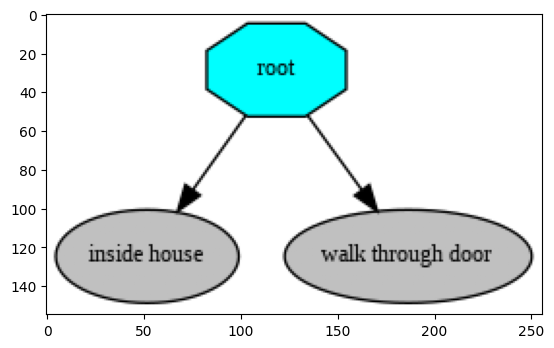

In [ ]:
render_dot_tree(treeRoot)
plt.imshow(img.imread('/content/root.png') )

### Exercise 3: A running action

In [ ]:
# A: Implement a condition node that always returns failure

class NewAction(Behaviour):
    def __init__(self, name):
        super(NewAction, self).__init__(name)
        self.counter = 0
        """ The constructor of this class """



    def setup(self):
        self.logger.debug(f"NewAction::setup {self.name}")
        """ This mehod Allows you to do some more initialization later, which cannot yet be done yet at the time of construction
            (e.g. after the node has been added to the tree).
            If you want to use this method you need to write the code that calls it yourself.
            However, you can probably ignore this method.
        """

    def initialise(self):
        self.logger.debug(f"NewAction::initialise {self.name}")
        """
            This method is called whenever a new execution of the action corresponding to this node must be started.
            That is, it is called when the node is ticked and:
                - This node has not been ticked before, or
                - After the previous tick, this node returned SUCCES or FAILURE
            So, if this node is ticked, and on the previous tick it returned RUNNING, then this method will *not* be called.
        """
        self.counter = 0

    def update(self):
        self.logger.debug(f"NewAction::update {self.name}")
        """
            This method is called every time the node is ticked.
            It must return SUCCESS, FAILURE, or RUNNING.
        """
        if self.counter < 2:
          self.counter+=1
          return Status.RUNNING
        else:
          return Status.SUCCESS

    def terminate(self, new_status:Status):
        self.logger.debug(f"NewAction::terminate {self.name}. Terminated with status {new_status}")
        """
            This method is called whenever the action corresponding to this node has finished its execution.
            That is, if the update() method has returned either SUCCESS or FAILURE.
        """

In [ ]:
# B: Adapt the main function

log_tree.level = log_tree.Level.DEBUG

treeRoot = Selector(name="root", memory=False)
insideHouse = AlwaysFail(name="inside house")
walkThroughDoor = NewAction(name="walk through door")

treeRoot.add_children([insideHouse, walkThroughDoor])

for i in range(1,20):
  try:
    print("New tick")
    treeRoot.tick_once()
    sleep(0.1)
  except KeyboardInterrupt:
    break

New tick
[DEBUG] root                 : Selector.tick()
[DEBUG] root                 : Selector.tick() [!RUNNING->reset current_child]
[DEBUG] inside house         : AlwaysFail.tick()
[DEBUG] inside house         : AlwaysFail::initialise inside house
[DEBUG] inside house         : AlwaysFail::update inside house
[DEBUG] inside house         : AlwaysFail.stop(Status.INVALID->Status.FAILURE)
[DEBUG] inside house         : AlwaysFail::terminate inside house. Terminated with status Status.FAILURE
[DEBUG] walk through door    : NewAction.tick()
[DEBUG] walk through door    : NewAction::initialise walk through door
[DEBUG] walk through door    : NewAction::update walk through door
New tick
[DEBUG] root                 : Selector.tick()
[DEBUG] inside house         : AlwaysFail.tick()
[DEBUG] inside house         : AlwaysFail::initialise inside house
[DEBUG] inside house         : AlwaysFail::update inside house
[DEBUG] inside house         : AlwaysFail.stop(Status.FAILURE)
[DEBUG] inside hou

### Exercise 4: Update the state

In [ ]:
# Variable class

class Environment:
  def __init__(self):
    self.AgentInsideHouse = None

In [ ]:
# Inside house class

class InsideHouse(Behaviour):
    def __init__(self, name, env):
        super(InsideHouse, self).__init__(name)
        self.env = env
        """ The constructor of this class """

    def setup(self):
        self.logger.debug(f"InsideHouse::setup {self.name}")
        """ This mehod Allows you to do some more initialization later, which cannot yet be done yet at the time of construction
            (e.g. after the node has been added to the tree).
            If you want to use this method you need to write the code that calls it yourself.
            However, you can probably ignore this method.
        """

    def initialise(self):
        self.logger.debug(f"InsideHouse::initialise {self.name}")
        """
            This method is called whenever a new execution of the action corresponding to this node must be started.
            That is, it is called when the node is ticked and:
                - This node has not been ticked before, or
                - After the previous tick, this node returned SUCCES or FAILURE
            So, if this node is ticked, and on the previous tick it returned RUNNING, then this method will *not* be called.
        """

    def update(self):
        self.logger.debug(f"InsideHouse::update {self.name}")
        """
            This method is called every time the node is ticked.
            It must return SUCCESS, FAILURE, or RUNNING.
        """
        if env.AgentInsideHouse == True:
          print("SUCCESS")
          return Status.SUCCESS
        else:
          print("FAILURE")
          return Status.FAILURE

    def terminate(self, new_status:Status):
        self.logger.debug(f"NewAction::terminate {self.name}. Terminated with status {new_status}")
        """
            This method is called whenever the action corresponding to this node has finished its execution.
            That is, if the update() method has returned either SUCCESS or FAILURE.
        """

In [ ]:
# A: Implement a condition node that always returns failure

class WalkThroughDoor(Behaviour):
    def __init__(self, name, env):
        super(WalkThroughDoor, self).__init__(name)
        self.env = env
        """ The constructor of this class """



    def setup(self):
        self.logger.debug(f"WalkThroughDoor::setup {self.name}")
        """ This mehod Allows you to do some more initialization later, which cannot yet be done yet at the time of construction
            (e.g. after the node has been added to the tree).
            If you want to use this method you need to write the code that calls it yourself.
            However, you can probably ignore this method.
        """

    def initialise(self):
        self.logger.debug(f"WalkThroughDoor::initialise {self.name}")
        """
            This method is called whenever a new execution of the action corresponding to this node must be started.
            That is, it is called when the node is ticked and:
                - This node has not been ticked before, or
                - After the previous tick, this node returned SUCCES or FAILURE
            So, if this node is ticked, and on the previous tick it returned RUNNING, then this method will *not* be called.
        """

    def update(self):
        self.logger.debug(f"WalkThroughDoor::update {self.name}")
        """
            This method is called every time the node is ticked.
            It must return SUCCESS, FAILURE, or RUNNING.
        """
        env.AgentInsideHouse = True
        return Status.SUCCESS

    def terminate(self, new_status:Status):
        self.logger.debug(f"WalkThroughDoor::terminate {self.name}. Terminated with status {new_status}")
        """
            This method is called whenever the action corresponding to this node has finished its execution.
            That is, if the update() method has returned either SUCCESS or FAILURE.
        """

In [ ]:
# B: Adapt the main function

log_tree.level = log_tree.Level.DEBUG

env = Environment()
treeRoot = Selector(name="root", memory=False)
insideHouse = InsideHouse(name="inside house", env=env)
walkThroughDoor = WalkThroughDoor(name="walk through door", env=env)

treeRoot.add_children([insideHouse, walkThroughDoor])

for i in range(1,20):
  try:
    print("New tick")
    treeRoot.tick_once()
    sleep(0.1)
  except KeyboardInterrupt:
    break

New tick
[DEBUG] root                 : Selector.tick()
[DEBUG] root                 : Selector.tick() [!RUNNING->reset current_child]
[DEBUG] inside house         : InsideHouse.tick()
[DEBUG] inside house         : InsideHouse::initialise inside house
[DEBUG] inside house         : InsideHouse::update inside house
FAILURE
[DEBUG] inside house         : InsideHouse.stop(Status.INVALID->Status.FAILURE)
[DEBUG] inside house         : NewAction::terminate inside house. Terminated with status Status.FAILURE
[DEBUG] walk through door    : WalkThroughDoor.tick()
[DEBUG] walk through door    : WalkThroughDoor::initialise walk through door
[DEBUG] walk through door    : WalkThroughDoor::update walk through door
[DEBUG] walk through door    : WalkThroughDoor.stop(Status.INVALID->Status.SUCCESS)
[DEBUG] walk through door    : WalkThroughDoor::terminate walk through door. Terminated with status Status.SUCCESS
New tick
[DEBUG] root                 : Selector.tick()
[DEBUG] root                 : S

We can see that it works because on the first tick InsideHouse returns failure, and then, after WalkThroughDoor is executed, InsideHouse always returns success.

### Exercise 5: Implement a full tree

I will use the recipe that Maria Pilligua did

##### Creating actions and conditions

In [ ]:
class Wisk_Mixture(Behaviour):
    def __init__(self, name):
        super(Wisk_Mixture, self).__init__(name)

    def setup(self):
        self.logger.debug(f"Wisk_Mixture::setup {self.name}")

    def initialise(self):
        self.logger.debug(f"Wisk_Mixture::initialise {self.name}")

    def update(self):
        self.logger.debug(f"Wisk_Mixture::update {self.name}")
        return Status.FAILURE

    def terminate(self, new_status:Status):
        self.logger.debug(f"Wisk_Mixture::terminate {self.name}. Terminated with status {new_status}")

In [ ]:
class Ingridients_In_Bowl(Behaviour):
    def __init__(self, name):
        super(Ingridients_In_Bowl, self).__init__(name)

    def setup(self):
        self.logger.debug(f"Ingridients_In_Bowl::setup {self.name}")

    def initialise(self):
        self.logger.debug(f"Ingridients_In_Bowl::initialise {self.name}")

    def update(self):
        self.logger.debug(f"Ingridients_In_Bowl::update {self.name}")
        return Status.FAILURE

    def terminate(self, new_status:Status):
        self.logger.debug(f"Ingridients_In_Bowl::terminate {self.name}. Terminated with status {new_status}")

In [ ]:
class Mixture_Mixed(Behaviour):
    def __init__(self, name):
        super(Mixture_Mixed, self).__init__(name)

    def setup(self):
        self.logger.debug(f"Mixture_Mixed::setup {self.name}")

    def initialise(self):
        self.logger.debug(f"Mixture_Mixed::initialise {self.name}")

    def update(self):
        self.logger.debug(f"Mixture_Mixed::update {self.name}")
        return Status.FAILURE

    def terminate(self, new_status:Status):
        self.logger.debug(f"Mixture_Mixed::terminate {self.name}. Terminated with status {new_status}")

In [ ]:
class Heat_Grease_Pan(Behaviour):
    def __init__(self, name):
        super(Heat_Grease_Pan, self).__init__(name)

    def setup(self):
        self.logger.debug(f"Heat_Grease_Pan::setup {self.name}")

    def initialise(self):
        self.logger.debug(f"Heat_Grease_Pan::initialise {self.name}")

    def update(self):
        self.logger.debug(f"Heat_Grease_Pan::update {self.name}")
        return Status.FAILURE

    def terminate(self, new_status:Status):
        self.logger.debug(f"Heat_Grease_Pan::terminate {self.name}. Terminated with status {new_status}")

In [ ]:
class Pan_Ready(Behaviour):
    def __init__(self, name):
        super(Pan_Ready, self).__init__(name)

    def setup(self):
        self.logger.debug(f"Pan_Ready::setup {self.name}")

    def initialise(self):
        self.logger.debug(f"Pan_Ready::initialise {self.name}")

    def update(self):
        self.logger.debug(f"Pan_Ready::update {self.name}")
        return Status.FAILURE

    def terminate(self, new_status:Status):
        self.logger.debug(f"Pan_Ready::terminate {self.name}. Terminated with status {new_status}")

In [ ]:
class Pour_Mixture(Behaviour):
    def __init__(self, name):
        super(Pour_Mixture, self).__init__(name)

    def setup(self):
        self.logger.debug(f"Pour_Mixture::setup {self.name}")

    def initialise(self):
        self.logger.debug(f"Pour_Mixture::initialise {self.name}")

    def update(self):
        self.logger.debug(f"Pour_Mixture::update {self.name}")
        return Status.FAILURE

    def terminate(self, new_status:Status):
        self.logger.debug(f"Pour_Mixture::terminate {self.name}. Terminated with status {new_status}")

In [ ]:
class Pancake_Cooked(Behaviour):
    def __init__(self, name):
        super(Pancake_Cooked, self).__init__(name)

    def setup(self):
        self.logger.debug(f"Pancake_Cooked::setup {self.name}")

    def initialise(self):
        self.logger.debug(f"Pancake_Cooked::initialise {self.name}")

    def update(self):
        self.logger.debug(f"Pancake_Cooked::update {self.name}")
        return Status.FAILURE

    def terminate(self, new_status:Status):
        self.logger.debug(f"Pancake_Cooked::terminate {self.name}. Terminated with status {new_status}")

In [ ]:
class Cook_Pancake(Behaviour):
    def __init__(self, name):
        super(Cook_Pancake, self).__init__(name)

    def setup(self):
        self.logger.debug(f"Cook_Pancake::setup {self.name}")

    def initialise(self):
        self.logger.debug(f"Cook_Pancake::initialise {self.name}")

    def update(self):
        self.logger.debug(f"Cook_Pancake::update {self.name}")
        return Status.FAILURE

    def terminate(self, new_status:Status):
        self.logger.debug(f"Cook_Pancake::terminate {self.name}. Terminated with status {new_status}")

In [ ]:
class Pancake_Ready(Behaviour):
    def __init__(self, name):
        super(Pancake_Ready, self).__init__(name)

    def setup(self):
        self.logger.debug(f"Pancake_Ready::setup {self.name}")

    def initialise(self):
        self.logger.debug(f"Pancake_Ready::initialise {self.name}")

    def update(self):
        self.logger.debug(f"Pancake_Ready::update {self.name}")
        return Status.FAILURE

    def terminate(self, new_status:Status):
        self.logger.debug(f"Pancake_Ready::terminate {self.name}. Terminated with status {new_status}")

##### Creating sequences and selectors

In [ ]:
seq_1 = Sequence(name="root", memory=False)

inginbowl = Ingridients_In_Bowl(name="ingredients in bowl")
wisk = Wisk_Mixture(name="wisk mixture")

seq_1.add_children([inginbowl, wisk])

In [ ]:
sel_1 = Selector(name="root", memory=False)

mixmix = Mixture_Mixed(name="mixture mixed")

sel_1.add_children([mixmix, seq_1])

In [ ]:
sel_2 = Selector(name="root", memory=False)

panr = Pan_Ready(name="pan ready")
heat = Heat_Grease_Pan(name="heat and grease pan")

sel_2.add_children([panr, heat])

In [ ]:
seq_2 = Sequence(name="root", memory=False)

panmix = Pour_Mixture(name="pour mixture on pan and wait")

seq_2.add_children([sel_2, sel_1, panmix])

In [ ]:
sel_3 = Selector(name="root", memory=False)

panco = Pancake_Cooked(name="pancake cooked")

sel_3.add_children([panco, seq_2])

In [ ]:
seq_3 = Sequence(name="root", memory=False)

copan = Cook_Pancake(name="cook pancake")

seq_3.add_children([sel_3, copan])

In [ ]:
root = Selector(name="root", memory=False)

done = Pancake_Ready(name="pancake ready!")

root.add_children([done, seq_3])

##### Drawing tree

Writing /content/root.dot
Writing /content/root.png
Writing /content/root.svg


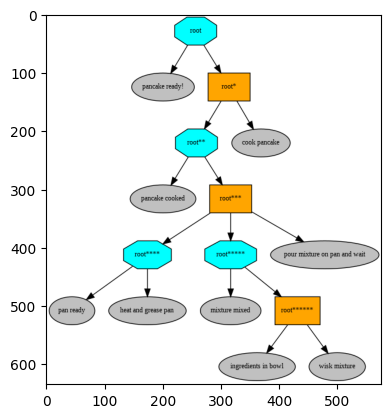

In [ ]:
render_dot_tree(root)
plt.imshow(img.imread('/content/root.png') )